In [1]:
using Plots
using LinearAlgebra

### Theoretical Part

$$u_{ex}(x, y) = (x + 1)(x - 1)(y + 1)(y - 1)$$

$${\Delta}u = \frac{\partial^2u}{{\partial}x^2} + \frac{\partial^2u}{{\partial}y^2} = div\ grad\ u$$

$$-{\Delta}u = g(x, y),\ for\ (x, y) {\in} {\Omega}$$

$$then:$$

$$
g(x, y) = -\{\frac{\partial^2(x + 1)(x - 1)(y + 1)(y - 1)}{{\partial}x^2}+\frac{\partial^2(x + 1)(x - 1)(y + 1)(y - 1)}{{\partial}y^2}\}
$$
$$= -\{(y + 1)(y - 1)\frac{\partial^2(x^2 - 1)}{{\partial}x^2} + (x + 1)(x - 1)\frac{\partial^2(y^2 - 1)}{{\partial}y^2}\}$$
$$= -2(y + 1)(y - 1) -2(x + 1)(x - 1)$$

### Implementation Part

In [2]:
# http://gmsh.info/bin/MacOSX/gmsh-4.0.5-MacOSX-sdk.tgz

In [3]:
include("gmsh-4.0.5-MacOSX-sdk/lib/gmsh.jl")

Main.gmsh

In [4]:
# Documentation
# https://gitlab.onelab.info/gmsh/gmsh/blob/master/api/gmsh.jl

In [5]:
# Tutorial generate mesh on rectangular domain with gmsh
# https://www.youtube.com/watch?v=NzumLVlz5jc

<img src="gmsh_fin.png" alt="gmsh_fin" width="600"/>

In [6]:
gmsh.initialize();
gmsh.open("unit_square_mesh.msh");

In [7]:
function ExactSolu(x, y)
    (x + 1) * (x - 1) * (y + 1) * (y - 1)
end

ExactSolu (generic function with 1 method)

In [8]:
ExactSolu(5, 5)

576

In [9]:
omega = [-1, 1]
n = 100;

x_range = range(omega[1], stop=omega[2], length=n);
y_range = range(omega[1], stop=omega[2], length=n);

plt = plot3d(1, xlim=omega, ylim=omega, zlim=(-0.1,1.1), marker = 1)

for x = x_range
    for y = y_range
        push!(plt, x, y, ExactSolu(x, y));
    end
end

plt

In [10]:
function SourceFct(x, y)
    - 2 * (y + 1) * (y - 1) - 2 * (x + 1) * (x - 1)
end

SourceFct (generic function with 1 method)

In [11]:
SourceFct(5, 5)

-96

In [12]:
gmsh.model.getDimension()

2

In [13]:
# `nodeTags` contains the node tags (their unique, strictly positive identification numbers).
# `coord` is a vector of length 3 times the length of `nodeTags` that contains the x, y, z
# coordinates of the nodes, concatenated: [n1x, n1y, n1z, n2x, ...].
nodeTags, coord, _ = gmsh.model.mesh.getNodes();

In [14]:
x = zeros(length(nodeTags), 3);
for i = 1:length(nodeTags)
    for j = 1:2
        x[i, j] = coord[(i - 1) * 3 + j];
        
        if (abs(x[i, j]) == 1.0)
            x[i, 3] = 1;
        end
    end
end

# Preview
x[78:82, :]

5×3 Array{Float64,2}:
 -0.7          -1.0          1.0
 -0.8          -1.0          1.0
 -0.9          -1.0          1.0
 -1.77013e-18  -4.86785e-18  0.0
 -0.414286     -0.414286     0.0

In [15]:
# `elementTypes` contains the MSH types of the elements (e.g. `2` for 3-node triangles:
# see `getElementProperties` to obtain the properties for a given element type).
# `elementTags` is a vector of the same length as `elementTypes`; each entry is a
# vector containing the tags (unique, strictly positive identifiers) of the
# elements of the corresponding type. `nodeTags` is also a vector of the same
# length as `elementTypes`; each entry is a vector of length equal to the number
# of elements of the given type times the number N of nodes for this type of
# element, that contains the node tags of all the elements of the given type,
# concatenated: [e1n1, e1n2, ..., e1nN, e2n1, ...].
elementTypes, elementTags, elementNodeTags = gmsh.model.mesh.getElements();

In [16]:
for t in elementTypes
    println(gmsh.model.mesh.getElementProperties(t))
end

("Line 2", 1, 1, 2, [-1.0, 1.0])
("Triangle 3", 2, 1, 3, [0.0, 0.0, 1.0, 0.0, 0.0, 1.0])
("Point", 0, 0, 1, [0.0])


In [17]:
triangleElementTags = elementTags[2];
triangleNodeTags = elementNodeTags[2];
println("Elements: ", length(triangleElementTags), ", nodes in elements: ", length(triangleNodeTags));

Elements: 1064, nodes in elements: 3192


In [18]:
elmat = trunc.(Int, zeros(length(triangleElementTags), 3));
for i = 1:length(triangleElementTags)
    for j = 1:3
        elmat[i, j] = triangleNodeTags[(i - 1) * 3 + j];
    end
end

# Preview
elmat[1:3, :]

3×3 Array{Int64,2}:
 194  127  519
 195  128  520
 196  129  521

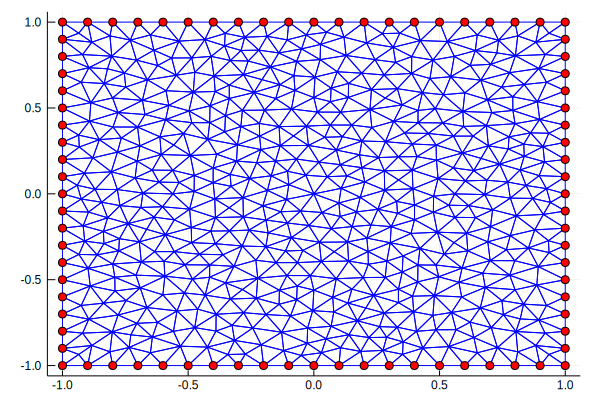

In [19]:
plt = plot(legend=false)

for i = 1:size(elmat, 1)
    tr = 
        [
            x[elmat[i, 1], 1] x[elmat[i, 1], 2]
            x[elmat[i, 2], 1] x[elmat[i, 2], 2]
            x[elmat[i, 3], 1] x[elmat[i, 3], 2]
            x[elmat[i, 1], 1] x[elmat[i, 1], 2]
        ]
    
    plot!(tr[:, 1], tr[:, 2], linecolor="blue")
end

for i = 1:size(x, 1)
    if (x[i, 3] == 1.0)
        scatter!([x[i, 1]], [x[i, 2]], color="red")
    end
end

plt

In [20]:
function GenerateElementMatrix(x1, x2, x3)
    area = abs(0.5 * det([x1[1] x1[2] 1; x2[1] x2[2] 1; x3[1] x3[2] 1]));
    
    abc1 = [x1[1] x1[2] 1; x2[1] x2[2] 1; x3[1] x3[2] 1] \ [1; 0; 0];
    abc2 = [x1[1] x1[2] 1; x2[1] x2[2] 1; x3[1] x3[2] 1] \ [0; 1; 0];
    abc3 = [x1[1] x1[2] 1; x2[1] x2[2] 1; x3[1] x3[2] 1] \ [0; 0; 1];
    
    a = [abc1[1] abc2[1] abc3[1]];
    b = [abc1[2] abc2[2] abc3[2]];
    # c = [abc1[3] abc2[3] abc3[3]];
    
    A_e_k = zeros(3, 3);
    
    for i = 1:3
        for j = 1:3
            A_e_k[i, j] = (a[i] * a[j] + b[i] * b[j]) * area;
        end
    end
    
    A_e_k
end

GenerateElementMatrix (generic function with 1 method)

In [21]:
function GenerateElementVector(x1, x2, x3)
    area = abs(0.5 * det([x1[1] x1[2] 1; x2[1] x2[2] 1; x3[1] x3[2] 1]));
    
    area / 3 * [
        SourceFct(x1[1], x1[2])
        SourceFct(x2[1], x2[2])
        SourceFct(x3[1], x3[2])
    ]
end

GenerateElementVector (generic function with 1 method)

In [22]:
function AssembleMatrix(x, elmat)
    nnodes = size(x, 1);
    S = zeros(nnodes, nnodes);
    
    for k = 1:size(elmat, 1)
        x1 = x[elmat[k, 1], :];
        x2 = x[elmat[k, 2], :];
        x3 = x[elmat[k, 3], :];
        
        S_e_k = GenerateElementMatrix(x1, x2, x3);
        
        for i = 1:3
            for j = 1:3
                S[elmat[k, i], elmat[k, j]] = S[elmat[k, i], elmat[k, j]] + S_e_k[i, j];
            end
        end
    end
    
    S
end

AssembleMatrix (generic function with 1 method)

In [23]:
function AssembleVector(x, elmat)
    nnodes = size(x, 1);
    f = zeros(nnodes, 1);
    
    for k = 1:size(elmat, 1)
        x1 = x[elmat[k, 1], :];
        x2 = x[elmat[k, 2], :];
        x3 = x[elmat[k, 3], :];
        
        f_e_k = GenerateElementVector(x1, x2, x3);
        
        for i = 1:3
            f[elmat[k, i]] = f[elmat[k, i]] + f_e_k[i];
        end
    end
    
    f
end

AssembleVector (generic function with 1 method)

In [24]:
S = AssembleMatrix(x, elmat);
f = AssembleVector(x, elmat);

# Dirichlet boundary conditions
cnt_bnd_pts = trunc.(Int, sum(x[:,3]));
for k = 1:cnt_bnd_pts
    for i = 1:size(S, 2) S[k, i] = 0; end
    S[k, k] = 1;
    f[k] = 0;
end

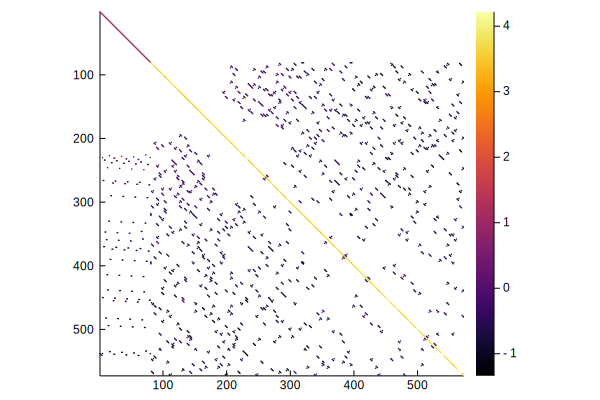

In [25]:
using SparseArrays
spy(sparse(S))

In [26]:
u_h = S \ f;

In [27]:
u = zeros(size(x, 1), 1);
for i = 1:size(x, 1)
    u[i] = ExactSolu(x[i, 1], x[i, 2]);
end

### Error between exact and approximate solution

In [28]:
err = sum([abs(x) for x in u_h - u])

0.3264916166121853

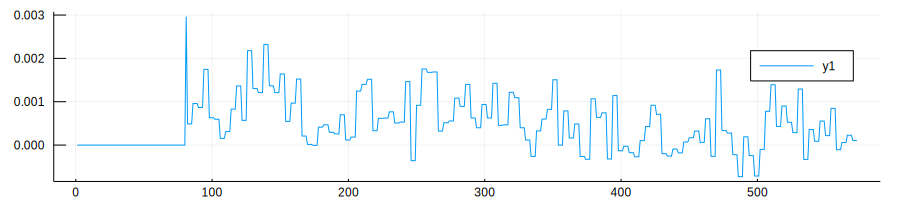

In [38]:
plot(u_h - u, size=(900, 200))

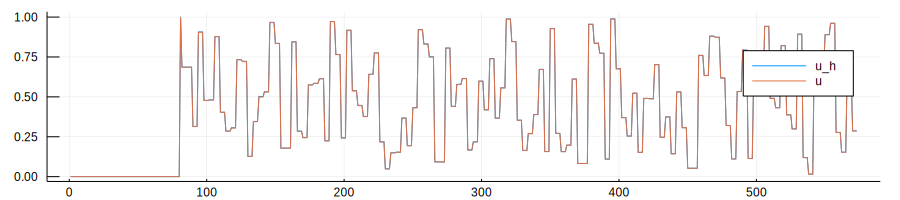

In [39]:
plot(u_h, label="u_h", size=(900, 200))
plot!(u, label="u")